In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
from sklearn.pipeline import Pipeline
from steps.feature import ImpactClassifier, ImpactWeigher, LastDiffFeatures
from steps.filter import ChampionReleaseFilter
from steps.reader import ReleaseReader, PlayHistoryReader, PatchHistoryReader
from steps.transform import HistoryCombiner, ImpactAggregator, ImpactDiscretizer
import joblib

cr_dict = ReleaseReader.from_csv('data/champions.csv', as_dict=True)
skins_df = ReleaseReader.from_csv('data/skins.csv')
play_df = PlayHistoryReader.from_jsonl('data/playhistory.jsonl')
impact = joblib.load('model/impact_classifier.pickle')

tf_pipeline = Pipeline([
    ('filter', ChampionReleaseFilter(cr_dict)),
    ('impact_clf', ImpactClassifier(impact)),
    ('impact_w', ImpactWeigher()),
    ('impact_agg', ImpactAggregator()),
    ('combiner', HistoryCombiner(play_df, skins_df)),
    ('impact_dsc', ImpactDiscretizer()),
    ('diff_fts', LastDiffFeatures())
])

raw_df = PatchHistoryReader.from_jsonl('data/patches.jsonl')
df = tf_pipeline.transform(raw_df)
df

,date,champion,diff,buff,nerf,popularity,winrate,banrate,skin,total_skins,popularity_delta,winrate_delta,banrate_delta,date_delta
0,2014-03-18,Aatrox,none,0.0,0.0,0.041186,0.5147,0.008651,0.0,1.0,0.000000,0.0000,0.000000,0.0
1,2014-04-03,Aatrox,none,0.0,0.0,0.044511,0.5064,0.002803,0.0,1.0,0.003325,-0.0083,-0.005848,2.0
2,2014-04-21,Aatrox,none,0.0,0.0,0.041942,0.5036,0.004218,0.0,1.0,0.000756,-0.0111,-0.004433,4.0
3,2014-05-08,Aatrox,none,0.0,0.0,0.035388,0.4981,0.005171,0.0,1.0,-0.005797,-0.0166,-0.003480,7.0
4,2014-05-22,Aatrox,none,0.0,0.0,0.026381,0.4941,0.006110,0.0,1.0,-0.014805,-0.0206,-0.002541,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25097,2022-01-05,Zyra,none,0.0,0.0,0.040819,0.5108,0.019420,0.0,8.0,0.008234,0.0021,0.010742,34.0
25098,2022-01-20,Zyra,none,0.0,0.0,0.031985,0.4984,0.010657,0.0,8.0,-0.000600,-0.0103,0.001979,36.0
25099,2022-02-02,Zyra,none,0.0,0.0,0.033227,0.5162,0.011589,0.0,8.0,0.000641,0.0075,0.002911,38.0
25100,2022-02-16,Zyra,none,0.0,0.0,0.034053,0.5159,0.011444,0.0,8.0,0.001468,0.0072,0.002765,40.0


## Medições de buff/nerf

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

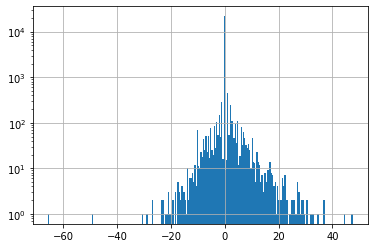

In [4]:
(df['buff'] - df['nerf']).hist(bins=250)
plt.yscale('log')
plt.show()

In [5]:
df['diff'].value_counts()

none      21771
buff       1497
nerf        972
adjust      862
Name: diff, dtype: int64

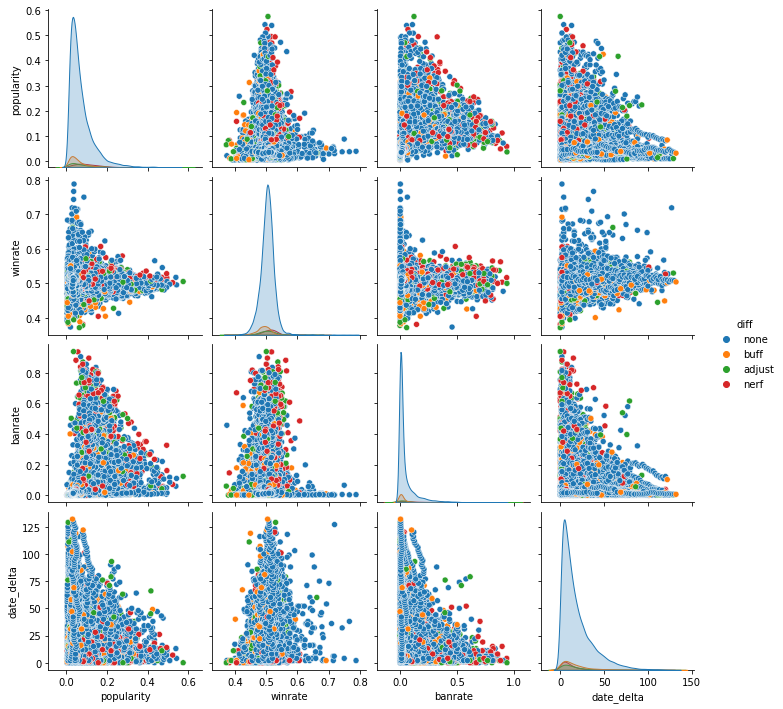

In [6]:
cols = ['popularity', 'winrate', 'banrate', 'date_delta']
sns.pairplot(df[cols + ['diff']], hue='diff')
plt.show()

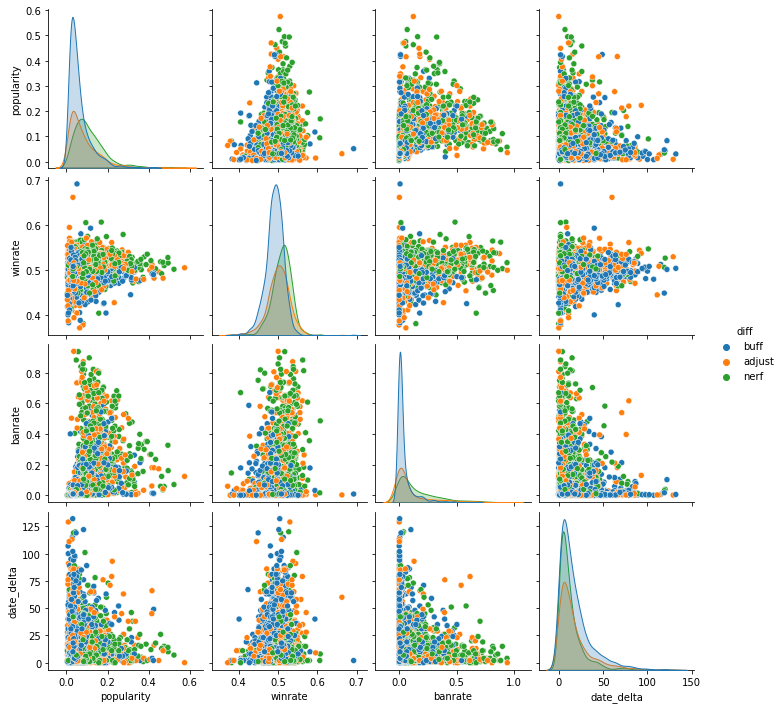

In [7]:
cols = ['popularity', 'winrate', 'banrate', 'date_delta']
sns.pairplot(df[df['diff'] != 'none'][cols + ['diff']], hue='diff')
plt.show()

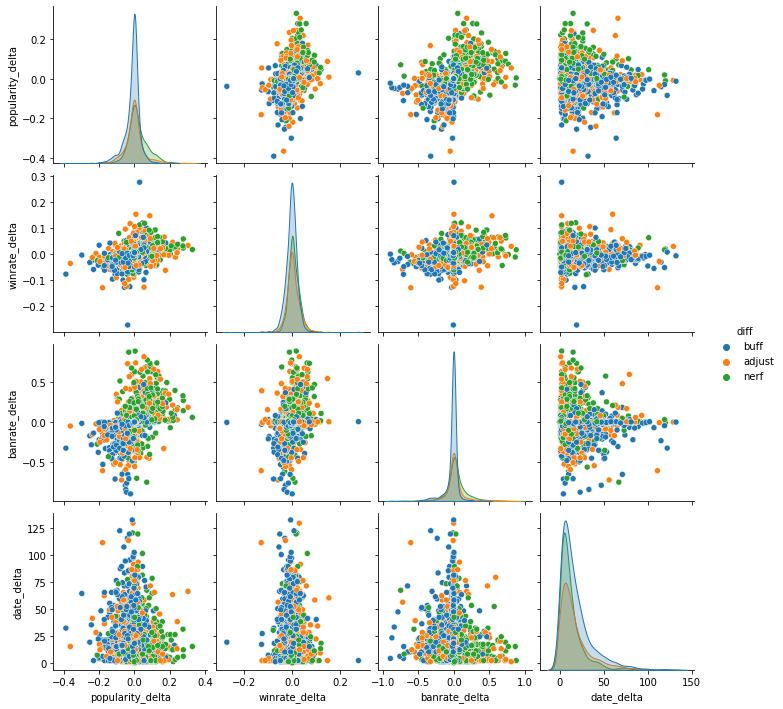

In [8]:
cols = ['popularity_delta', 'winrate_delta', 'banrate_delta', 'date_delta']
sns.pairplot(df[df['diff'] != 'none'][cols + ['diff']], hue='diff')
plt.show()

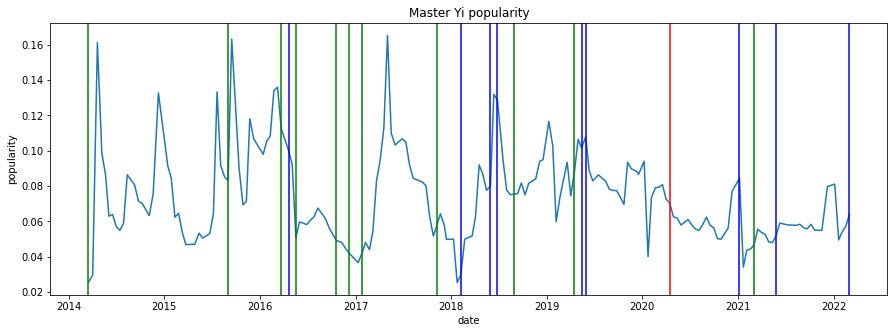

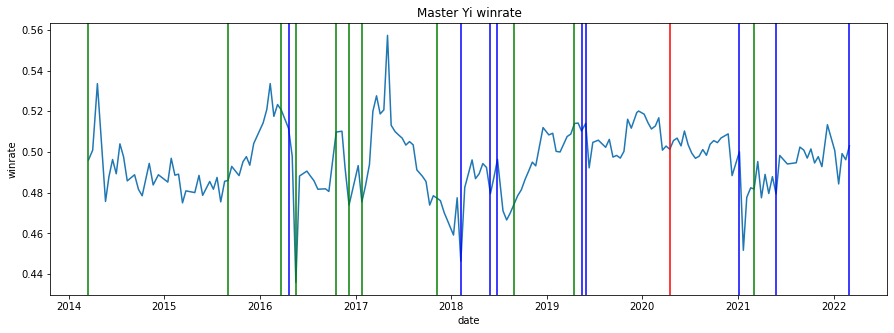

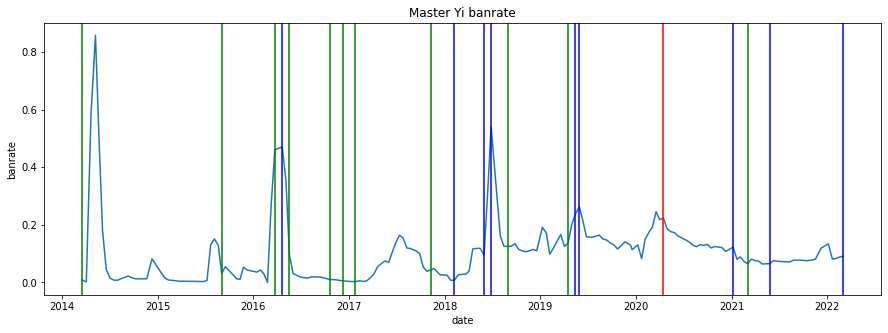

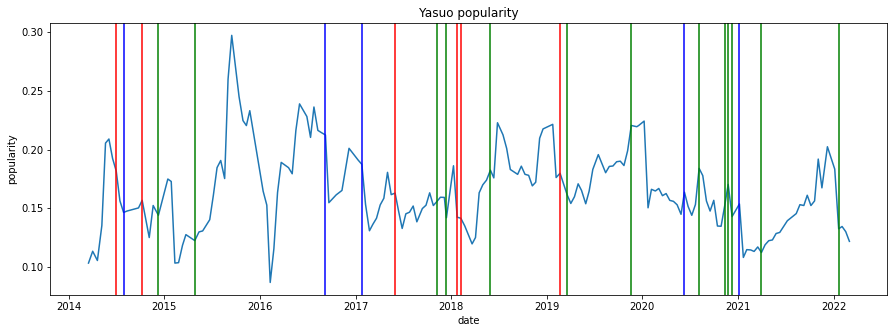

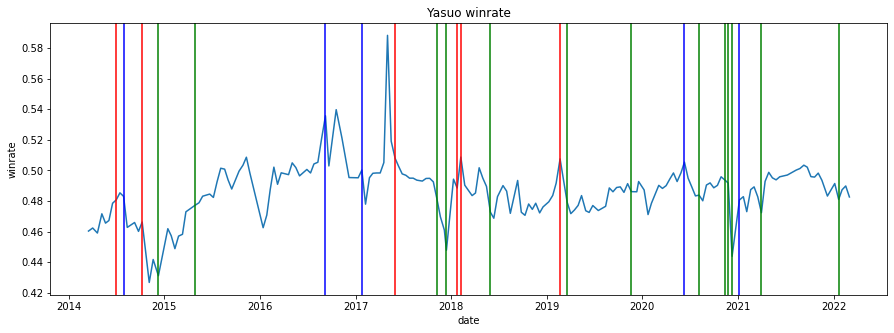

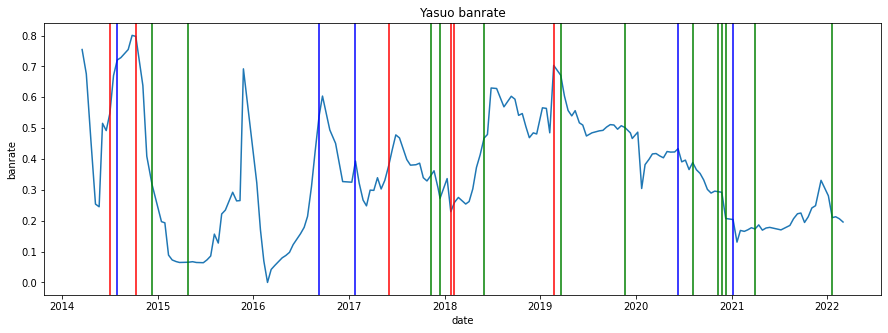

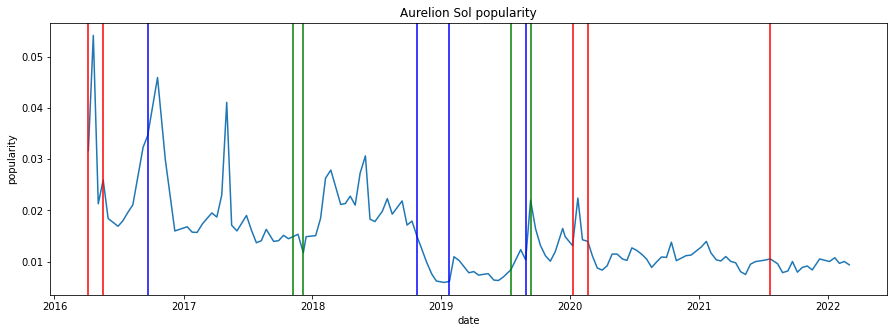

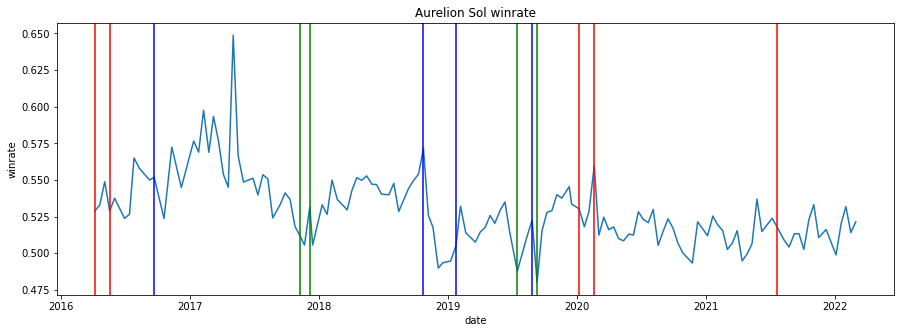

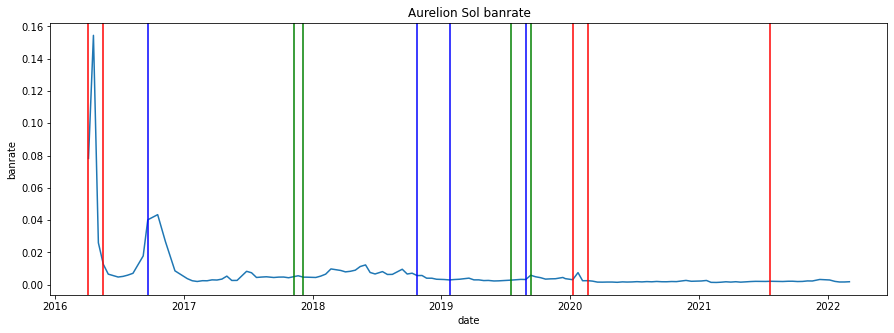

In [9]:
ys = ['popularity', 'winrate', 'banrate']
axvcolor = {'buff': 'green', 'nerf': 'red', 'adjust': 'blue'}

def history_with_diff(df, champion):
    df_ = df[df['champion'] == champion]
    for y in ys:
        fig, ax = plt.subplots(figsize=(15,5))
        sns.lineplot(data=df_, x='date', y=y, ax=ax)
        for _, row in df_.iterrows():
            date, diff = row['date'], row['diff']
            if diff == 'none':
                continue
            plt.axvline(x=date, color=axvcolor[diff])
        plt.title(f'{champion} {y}')
        plt.show()

history_with_diff(df, "Master Yi")
history_with_diff(df, "Yasuo")
history_with_diff(df, "Aurelion Sol")

In [10]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split

def evaluate(model, X, y, label, scoring='accuracy', cv=5):
    print(f'=== {label} ===')
    score = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f"Cross val {scoring}: {score.mean():.2f} (+/- {score.std() * 2:.2f})")
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(train_x, train_y)
    predicted = model.predict(test_x)
    print(classification_report(test_y, predicted))

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

X = df[['popularity', 'winrate', 'banrate', 'skin',
    'popularity_delta', 'winrate_delta', 'banrate_delta', 'date_delta']]
y = df['diff']

evaluate(GradientBoostingClassifier(), X, y, 'GradientBoostingClassifier')

=== GradientBoostingClassifier ===
Cross val accuracy: 0.86 (+/- 0.01)
              precision    recall  f1-score   support

      adjust       0.38      0.02      0.03       190
        buff       0.25      0.00      0.01       305
        nerf       0.48      0.06      0.10       188
        none       0.87      1.00      0.93      4338

    accuracy                           0.86      5021
   macro avg       0.49      0.27      0.27      5021
weighted avg       0.80      0.86      0.81      5021



In [12]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

def curves(model, X, y, label):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(train_x, train_y)
    plot_precision_recall_curve(model, test_x, test_y, name=label)
    plot_roc_curve(model, test_x, test_y, name=label)

=== GradientBoostingClassifier ===
Cross val f1_macro: 0.51 (+/- 0.01)
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      4338
        True       0.67      0.05      0.10       683

    accuracy                           0.87      5021
   macro avg       0.77      0.52      0.51      5021
weighted avg       0.84      0.87      0.82      5021



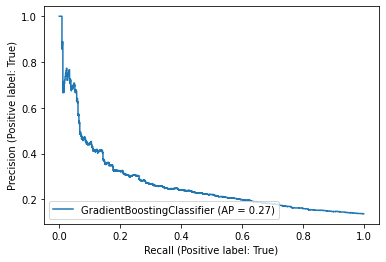

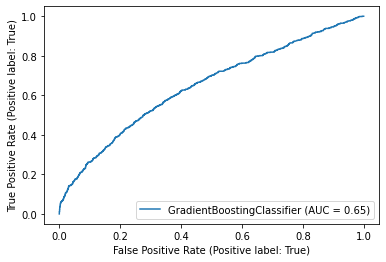

In [13]:
model = GradientBoostingClassifier()


evaluate(model, X, y != 'none', 'GradientBoostingClassifier', scoring='f1_macro')
curves(model, X, y != 'none', 'GradientBoostingClassifier')

In [14]:
from steps.classifier import ChangedClassifier

changed_model = ChangedClassifier(GradientBoostingClassifier(), threshold=0.2)
evaluate(changed_model, X, y != 'none', 'Changed + GradientBoostingClassifier', scoring='f1_macro')

=== Changed + GradientBoostingClassifier ===
Cross val f1_macro: 0.57 (+/- 0.02)
              precision    recall  f1-score   support

       False       0.88      0.92      0.90      4338
        True       0.31      0.22      0.26       683

    accuracy                           0.83      5021
   macro avg       0.59      0.57      0.58      5021
weighted avg       0.80      0.83      0.81      5021



In [15]:
from sklearn.ensemble import RandomForestClassifier


diff_model = RandomForestClassifier()
evaluate(diff_model, X[y != 'none'], y[y != 'none'], 'RandomForestClassifier')

=== RandomForestClassifier ===
Cross val accuracy: 0.56 (+/- 0.02)
              precision    recall  f1-score   support

      adjust       0.36      0.17      0.23       159
        buff       0.62      0.77      0.68       311
        nerf       0.56      0.57      0.56       197

    accuracy                           0.57       667
   macro avg       0.51      0.50      0.49       667
weighted avg       0.54      0.57      0.54       667



In [16]:
import joblib
import os

if not os.path.exists('model'):
  os.mkdir('model')

model.fit(X, y)
joblib.dump(changed_model, 'model/changed_classifier.pickle')
joblib.dump(diff_model, 'model/diff_classifier.pickle')

['model/diff_classifier.pickle']